In [4]:
using Plots
using Random
using StatsBase
using Statistics

In [12]:


module SwapologyMC

using Random
using Statistics
using StatsBase
using Plots

spin(b::Bool) = Float64(2 * b - 1)

function magnetization(c::AbstractMatrix{Bool})  
    """
    returns: mean magnetization of the spin configuration
    """
    Lx,Ly=size(c)
    N=Lx*Ly
    mean_magnetization = 2*count(c)/N - 1.0
   
    return mean_magnetization
end

function meas_mag(c::AbstractMatrix{Bool}, Jx::Float64, Jy::Float64, h::Float64)
    """
    returns: mean magnetization of the spin configuration
    """
    return magnetization(c)
end

function Swapology_cluster_update!(c::AbstractArray{Bool}, l::Int64, beta::Float64, J::Float64)
    """
    Implementing cluster update algorithm
    return: the ratio size of the updated cluster with respect to the system size
    """
    Lx, Ly = size(c)
    N_spins = Lx*Ly
    
    #Choosing a random site
    nx = rand(1:Lx)
    ny = rand(1:Ly)
    
    #Getting the direction of the random spin
    refspin = c[nx,ny] #defining the direction of the potential cluster
    oppspin = !c[nx,ny] #defining the opposite direction
    
    c[nx,ny] = oppspin #flipping the random spin
    
    stack = [(nx,ny)] #List of spins to be visited
    num_tobevisited = 1
    
    size_cluster = 1 #size of the cluster
    
    while num_tobevisited > 0 #as long as the number of spins to be visited is > 0
        
        current_spin = stack[num_tobevisited] #current spin is the last spin in the stack array
        pop!(stack)
        num_tobevisited -= 1
        
        nns = neighbours_replica(current_spin[1], current_spin[2], Lx, Ly ÷ 2, l)
        
        for (a,b) in nns
            if c[a,b] == refspin && rand() < (1-exp(-2*beta*J))
                push!(stack, (a,b))
                num_tobevisited += 1
                c[a,b] = oppspin 
                size_cluster +=1
            end
        end
    end
    
    return size_cluster/N_spins
end

function Swapology_sampledata_clusterupdate(Lx::Int64, Ly::Int64, l::Int64, δ::Int64, n_sweeps::Int64, β::Float64, J::Float64;
        c_init = nothing, meas_func = nothing)
        
        # sampledata that takes the following as arguments
        # Lx, Ly: dimensions of system
        # l: Size of subsystem
        # n_sweeps: number of sweeps
        # β: 1/Temperature
        # J: Isotropic coupling
        # c_init: BitArray representing initial configuration
        # meas_func: Function that calculates observable for each config
        #---------------------------------------------------------------
    
        """
        returns measured data array and mean ratio of the clusters with respect to the system size
        """
        if c_init == nothing
            c_init = bitrand(Lx,2*Ly)
        end
        if (Lx, 2*Ly) != size(c_init)
            @error "Wrong configuration size or choice"
        end
        
        #work on copy of initial configuration
        
        config = copy(c_init)
        N = 2*Lx*Ly
        data_list = zeros(n_sweeps)
        size_ratio = 0.0 #ratio size of cluster
    
        numerator_count, denominator_count = (0, 1)
        frac_history = zeros(n_sweeps)
        topology_history = falses(n_sweeps)
        current_topology = "denominator"
        
        for i in 1:n_sweeps
        
            ### topology shift
            
            if current_topology == "numerator"
            
                r = 1.0/ratio(config, J, β, l, δ, Lx, Ly)

                if r > 1 || rand() < r
                    current_topology = "denominator"
                    denominator_count += 1
                    size_ratio += Swapology_cluster_update!(config, l, β, J)
                else
                    size_ratio += Swapology_cluster_update!(config, l+δ, β, J)
                    numerator_count +=1

                end
            else
                r = ratio(config, J, β, l, δ, Lx, Ly)
                
                if r > 1 || rand() < r
                    current_topology = "numerator"
                    numerator_count += 1
                    size_ratio += Swapology_cluster_update!(config, l+δ, β, J)
                else
                    size_ratio += Swapology_cluster_update!(config, l, β, J)
                    denominator_count += 1
                end
            
            end
            
            frac_history[i] = numerator_count/denominator_count
            topology_history[i] = (current_topology == "numerator")
        
            ####################
            
            if meas_func == nothing
                data_list[i] = NaN
            else
                data_list[i] = meas_func(config, J, J, 0.0)
            end
        

        end
    
        size_ratio = size_ratio/n_sweeps
        return data_list, size_ratio, frac_history, topology_history
end

function neighbours_replica(nx::Int,ny::Int,Lx::Int,Ly::Int,l::Int)
    
    #new neighbour function for replica topology
    #Lx and Ly is length of a single system
    #l is the length of subsystem
    
    if nx <= l
        
        return ((mod1(nx+1, Lx), ny),
                (mod1(nx-1, Lx), ny), 
                (nx, mod1(ny+1, 2*Ly)),
                (nx, mod1(ny-1, 2*Ly)))
        
    elseif ny <= Ly
        
        return ((mod1(nx+1, Lx), ny),
                (mod1(nx-1, Lx), ny), 
                (nx, mod1(ny+1, Ly)),
                (nx, mod1(ny-1, Ly)))
        
    else 
        
        return ((mod1(nx+1, Lx), ny),
                (mod1(nx-1, Lx), ny), 
                (nx, mod1(ny+1, Ly)+Ly),
                (nx, mod1(ny-1, Ly)+Ly))
    end
end

function local_ratio(c::AbstractArray{Bool}, J::Float64, beta::Float64, l::Int64 ,Lx::Int64, Ly::Int64)
    
    E_top = -J*(spin(c[l+1, Ly])*spin(c[l+1, Ly+1]) + spin(c[l+1, 1])*spin(c[l+1, 2*Ly]))
    E_bottom =  -J*(spin(c[l+1, 1])*spin(c[l+1, Ly]) + spin(c[l+1, Ly+1])*spin(c[l+1, 2*Ly]))
    
    return exp(-beta*(E_top-E_bottom))
end

function ratio(c::AbstractArray{Bool}, J::Float64, β::Float64, l::Int64, δ::Int64 ,Lx::Int64, Ly::Int64)
    
    ratio = 1.0
    
    for i=l:l+δ-1
        ratio *= local_ratio(c, J, β, i, Lx, Ly)
    end
    return ratio
    
end

function make_bins(v::Array{T,1}, bin_length::Int64) where T<:Number

    

    nbins = length(v)÷bin_length

    output = zeros(nbins)

    

    for i in 1:nbins

        output[i] = mean(v[((i-1)*bin_length +1) : i*bin_length])

    end

        

    return output

end

function make_bins_topology(v::BitArray{1}, bin_length::Int64) 

    

    nbins = length(v)÷bin_length

    output = zeros(nbins)

    

    for i in 1:nbins
        
        
        numerator_count = count(v[((i-1)*bin_length +1) : i*bin_length])
        denominator_count = bin_length - numerator_count
        fraction = numerator_count/denominator_count
        output[i] = fraction

    end

        

    return output

end

function meas_stat(v_binned::Array{T,1}) where T <: Number

    

    μ = mean(v_binned)

    v = var(v_binned)/length(v_binned)

    

    return (μ, sqrt(v))

end

end

Main.SwapologyMC

In [2]:
dl, sr, fh,th = SwapologyMC.Swapology_sampledata_clusterupdate(20, 100, 0, 2, 200000, 1/2.269, 1.0, meas_func=SwapologyMC.meas_mag)

([-0.018, -0.0175, -0.0185, -0.02, -0.0255, -0.0265, -0.028, -0.0255, -0.025, -0.0255  …  0.72, -0.0625, 0.401, 0.4, -0.096, 0.0365, -0.217, 0.0165, 0.384, 0.2755], 0.13984860999998108, [1.0, 0.5, 1.0, 0.666667, 1.0, 0.75, 1.0, 0.8, 1.0, 0.833333  …  0.675213, 0.675208, 0.675216, 0.67521, 0.675219, 0.675213, 0.675222, 0.675216, 0.675224, 0.675219], Bool[true, false, true, false, true, false, true, false, true, false  …  false, false, true, false, true, false, true, false, true, false])

In [5]:
plot(1:200000, fh, legend=false)

In [8]:
mean(fh[2500:end])

0.6770444373082398

In [13]:
function Renyi_Scaling(Lx::Int64, Ly::Int64, δ::Int64 , n_sweeps::Int64, β::Float64, J::Float64;
        c_init = nothing, meas_func = SwapologyMC.meas_mag)
    
    fh_arr=[]
    fh_error=[]
    Renyi=[]
    push!(Renyi,-1*log(mean(SwapologyMC.Swapology_sampledata_clusterupdate(Lx, Ly, 0, 0, n_sweeps, β, J, meas_func=SwapologyMC.meas_mag)[3][2500:end])))
    push!(fh_error,0)
    for l in 0:δ:Lx-δ
        dl, sr, fh, th = SwapologyMC.Swapology_sampledata_clusterupdate(Lx, Ly, l, δ, n_sweeps, β, J, meas_func=SwapologyMC.meas_mag)
        binned_data =SwapologyMC.make_bins_topology(th,1000) 
        x,sigma=SwapologyMC.meas_stat(binned_data)
        push!(fh_arr, x)
        push!(fh_error, sigma^2/x^2)
        push!(Renyi, -log(x))
    end
    cumsum!(Renyi,Renyi)
    cumsum!(fh_error, fh_error)
    
    return Renyi,sqrt.(fh_error)
end
    
    
    

Renyi_Scaling (generic function with 1 method)

In [14]:
Renyi, err= Renyi_Scaling(20, 100, 2, 200000,1/2.269, 1.0)

(Any[2.21857e-5, 0.392313, 0.486282, 0.527963, 0.548968, 0.556192, 0.554561, 0.534682, 0.495181, 0.399803, 0.0151069], [0.0, 0.00633693, 0.00843205, 0.010401, 0.0116566, 0.0128274, 0.0138158, 0.0148369, 0.0157121, 0.0166158, 0.0177662])

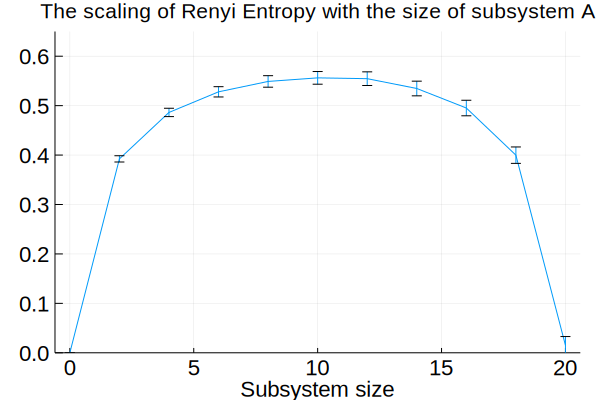

In [15]:
plot(0:2:20,Renyi, yerror= err, legend=false, ylims=(0,0.65),xaxis = (font(15,"Calibri")), yaxis = (font(15,"Calibri")))
xlabel!("Subsystem size")
ylabel!("")
title!("The scaling of Renyi Entropy with the size of subsystem A")

In [16]:
savefig("Renyi_entropy.png")

In [17]:
Lx=20
Ly=100

100

In [18]:
x = log.((Lx/π)*sin.(π * (0:2:Lx)/Lx))


11-element Array{Float64,1}:
 -Inf                 
    0.676643382085042 
    1.319608772723369 
    1.639067032204249 
    1.8008205977829723
    1.851002387704591 
    1.8008205977829725
    1.639067032204249 
    1.3196087727233692
    0.6766433820850424
  -34.78770662500439  

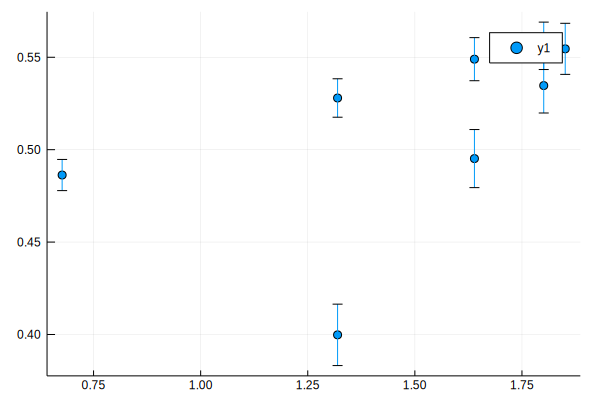

In [19]:
scatter(x[2:9], Renyi[3:10], yerror = err[3:10])

In [20]:
function linreg(x::AbstractArray, y::AbstractArray, w::AbstractArray)
    sw = sqrt.(w)

    [sw sw .* x] \ (sw .* y)
end

b,a = linreg(x[2:10], Renyi[2:10], 1 ./ err[2:10].^2)



2-element Array{Float64,1}:
 0.2989169877611754 
 0.14089472559562666

In [21]:
a*4

0.5635789023825066

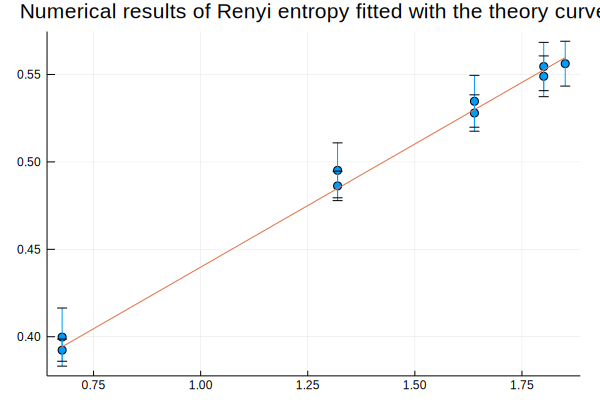

In [22]:
scatter(x[2:10], Renyi[2:10], yerror = err[2:10])
plot!(x[2:10], a .* x[2:10] .+  b , legend=false)
xlabel!("")
ylabel!("")
title!("Numerical results of Renyi entropy fitted with the theory curve") 

In [23]:
using LsqFit

@. model(x,p) = p[1] + p[2]*x

fit = curve_fit(model, x[2:10], Renyi[2:10], 1 ./ err[2:10].^2, [1.0, 1.0])

println(coef(fit))

stderror(fit)

[0.298917, 0.140895]


2-element Array{Float64,1}:
 0.01015780964696065
 0.00754635745507931

In [24]:
4*coef(fit)

2-element Array{Float64,1}:
 1.19566795076846  
 0.5635789025877352

In [25]:
4*stderror(fit)

2-element Array{Float64,1}:
 0.0406312385878426 
 0.03018542982031724